In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.metrics import (confusion_matrix, roc_curve, auc, f1_score, recall_score,
                             precision_score, classification_report, make_scorer, 
                             precision_recall_curve, average_precision_score, roc_auc_score)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [27]:
train_df = pd.read_excel("Train Fraud.xlsx")
test_df = pd.read_excel("Test Fraud - Alunos.xlsx")

target = 'Fraude'
features = [col for col in train_df.columns if col != target]

In [28]:
numerical_cols = train_df[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_df[features].select_dtypes(include=['object', 'category']).columns.tolist()

train_df[numerical_cols] = train_df[numerical_cols].fillna(train_df[numerical_cols].mean())
test_df[numerical_cols] = test_df[numerical_cols].fillna(train_df[numerical_cols].mean())

train_df[categorical_cols] = train_df[categorical_cols].fillna("desconhecido")
test_df[categorical_cols] = test_df[categorical_cols].fillna("desconhecido")

low_cardinality = [col for col in categorical_cols if train_df[col].nunique() <= 10]
high_cardinality = [col for col in categorical_cols if train_df[col].nunique() > 10]

for col in high_cardinality:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

train_df = pd.get_dummies(train_df, columns=low_cardinality)
test_df = pd.get_dummies(test_df, columns=low_cardinality)

train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

In [29]:
X = train_df.drop(columns=[target])
y = train_df[target]
X_test_final = test_df.copy()
if 'Fraude' in X_test_final.columns:
    X_test_final = X_test_final.drop(columns=['Fraude'])

corrs = X.corrwith(y).abs()
suspect_vars = corrs[corrs > 0.95].index.tolist()
if suspect_vars:
    print("Removendo variáveis com alta correlação com o target:", suspect_vars)
    X.drop(columns=suspect_vars, inplace=True)
    X_test_final.drop(columns=[col for col in suspect_vars if col in X_test_final.columns], inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test_final)

rfe_selector = RFE(estimator=RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=10)
X_selected = rfe_selector.fit_transform(X_scaled, y)
X_test_selected = rfe_selector.transform(X_test_scaled)

smote = SMOTE(sampling_strategy=0.3, random_state=42, k_neighbors=5)
X_train, y_train = smote.fit_resample(X_selected, y)

# Embaralhar as amostras para evitar que o modelo decore padrões artificiais do oversampling
shuffle_idx = np.random.permutation(len(y_train))
X_train = X_train[shuffle_idx]
y_train = y_train[shuffle_idx]

In [30]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model_lgbm = Pipeline(steps=[
    ('model', LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        random_state=42,
        n_jobs=-1,
        n_estimators=100,
        learning_rate=0.01,
        max_depth=3,
        num_leaves=5,
        min_child_samples=25,
        min_child_weight=0.05,
        subsample=0.7,
        colsample_bytree=0.7,
        scale_pos_weight=scale_pos_weight,
        reg_alpha=1.0,
        reg_lambda=2.0,
        verbose=-1
    ))
])

model_xgb = Pipeline(steps=[
    ('model', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        learning_rate=0.01,
        max_depth=3,
        n_estimators=100,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=1.0,
        reg_lambda=2.0,
        verbosity=0
    ))
])

models = {'LightGBM': model_lgbm, 'XGBoost': model_xgb}


Modelo: LightGBM
Precision: 0.9999, Recall: 0.9869, F1: 0.9933, AUC: 0.9996

Modelo: XGBoost
Precision: 0.9943, Recall: 0.9896, F1: 0.9919, AUC: 0.9995


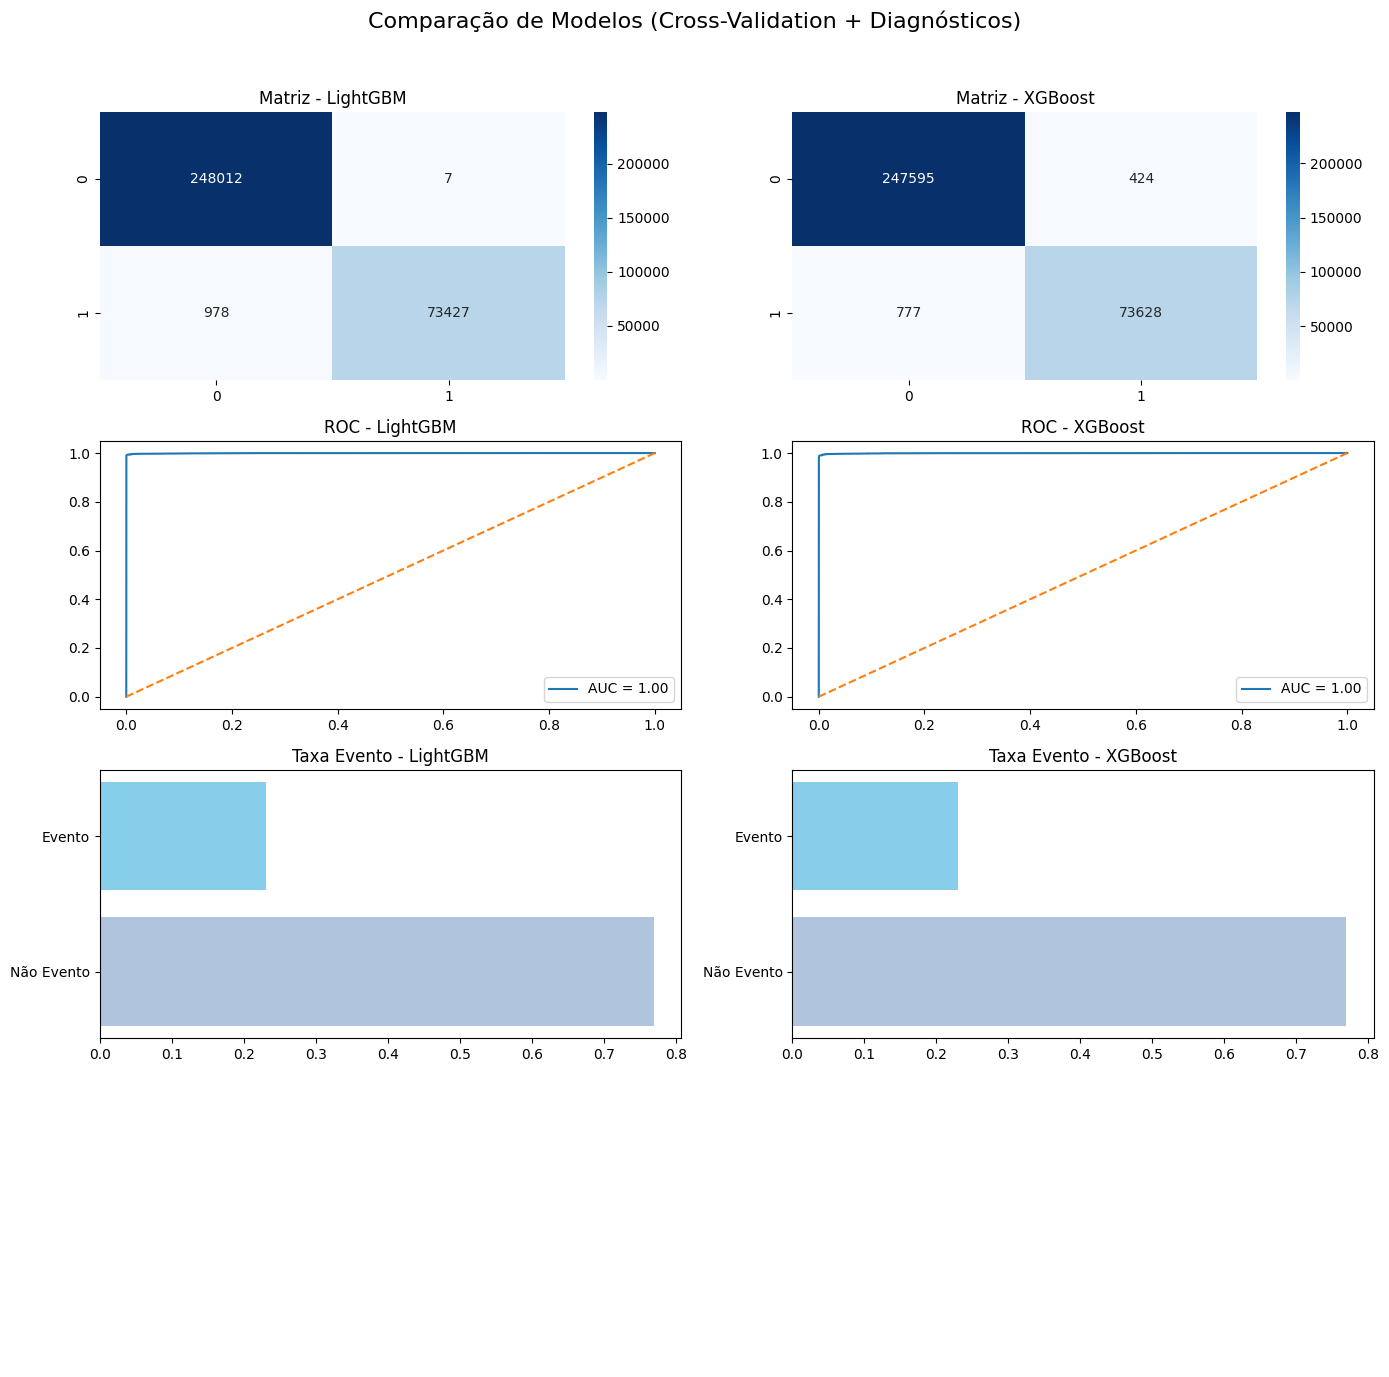

In [31]:
def comparar_modelos_cv(modelos, X, y):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 14))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for i, (nome, modelo) in enumerate(modelos.items()):
        probs = cross_val_predict(modelo, X, y, cv=cv, method='predict_proba')[:, 1]
        preds = (probs >= 0.5).astype(int)
        auc_val = roc_auc_score(y, probs)
        f1_val = f1_score(y, preds)
        recall_val = recall_score(y, preds)
        precision_val = precision_score(y, preds)

        sns.heatmap(confusion_matrix(y, preds), annot=True, fmt='d', cmap='Blues', ax=axes[0, i])
        axes[0, i].set_title(f"Matriz - {nome}")

        fpr, tpr, _ = roc_curve(y, probs)
        axes[1, i].plot(fpr, tpr, label=f"AUC = {auc_val:.2f}")
        axes[1, i].plot([0, 1], [0, 1], linestyle='--')
        axes[1, i].set_title(f'ROC - {nome}')
        axes[1, i].legend()

        event_rate = y.mean()
        axes[2, i].barh(['Não Evento', 'Evento'], [1 - event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
        axes[2, i].set_title(f'Taxa Evento - {nome}')

        if hasattr(modelo.named_steps['model'], 'feature_importances_'):
            importances = modelo.named_steps['model'].feature_importances_
            axes[3, i].bar(range(len(importances)), importances, color='skyblue')
            axes[3, i].set_title(f'Importância - {nome}')
        else:
            axes[3, i].axis('off')

        print(f"\nModelo: {nome}")
        print(f"Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1: {f1_val:.4f}, AUC: {auc_val:.4f}")

    plt.suptitle("Comparação de Modelos (Cross-Validation + Diagnósticos)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

comparar_modelos_cv(models, X_train, y_train)

In [32]:
model_lgbm.fit(X_train, y_train)
final_probs = model_lgbm.predict_proba(X_test_selected)[:, 1]
final_preds = (final_probs >= 0.5).astype(int)

submission = pd.DataFrame({'Fraude_Prevista': final_preds})
submission.to_excel("submissao_final.xlsx", index=False)